In [1]:
TF_DIR = "/home/input/openpose_tryout/tf-pose-estimation"

In [2]:
# 初回だけ必要

#!git clone https://github.com/okojoalg/tf-pose-estimation
#%cd "$TF_DIR"
# !pip install -r requirements.txt
# !apt -q -y install swig
# %cd "$TF_DIR"/models/graph/cmu
# !bash download.sh
# %cd "$TF_DIR"/tf_pose/pafprocess
# !swig -python -c++ pafprocess.i && python3 setup.py build_ext --inplace
# !pip uninstall -y tensorflow
# !pip install tensorflow-gpu==1.15 
# !pip install ffmpeg-python
# %cd "$TF_DIR"
# !pip install ffmpeg-python
# %cd "$TF_DIR"



In [3]:
%cd "$TF_DIR"

/home/input/openpose_tryout/tf-pose-estimation


In [4]:
!pwd

/home/input/openpose_tryout/tf-pose-estimation


In [5]:
import logging
import ffmpeg
import re
import shutil
import sys
import time
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt

from pylab import rcParams

from tf_pose import common
from tf_pose.estimator import TfPoseEstimator
from tf_pose.networks import get_graph_path, model_wh

# matplotlib inlineにした場合、メモリリークのバグがあり、グラフ出力処理で強制的に落ちるため、インライン表示をやめるようにしました。
%matplotlib

Using matplotlib backend: agg


In [18]:
##################################
#  独自ライブラリー： mshow
# (複数に対応したノートブック上画像表示)
##################################
import cv2;import numpy as np;import matplotlib as mpl;import matplotlib.pyplot as plt
%matplotlib inline
def mshow(img1=None, img2=None, img3=None, img4=None, img5=None, *, img_list = []):

    imgs = list(filter( lambda x: x is not None, [img1, img2, img3, img4, img5])) 
    imgs.extend(img_list)
    
    if len(imgs) == 1:
        # 一枚のとき
        imgs[0] = imgs[0].astype(np.uint8)
        im4p = cv2.cvtColor(imgs[0], cv2.COLOR_BGR2RGB)
        plt.imshow(im4p)

    elif len(imgs) < 10:
        # 複数枚のとき。横に並べていく
        plt.figure(figsize=(len(imgs)*6, len(imgs)*6))
        fig_exh_base = 100+len(imgs)*10
        for idx, tmp_img in enumerate(imgs):
            tmp_img = tmp_img.astype(np.uint8)
            tmp_im4p = cv2.cvtColor(tmp_img, cv2.COLOR_BGR2RGB)
            
            plt.subplot(fig_exh_base+idx+1)
            plt.imshow(tmp_im4p)
        
    else :
        plt.figure(figsize=(4*4, 4*4))
        for i in range(5):
            for j in range(5):
                
                if len(imgs) < 5*i+j+1:
                    break
                
                plt.subplot2grid((5,5), (i,j))
                plt.imshow(imgs[5*i+j])
        
        
        

In [19]:
# import urllib.request ;import cv2; import matplotlib.pyplot as plt; import numpy as np
# img_url = 'https://slack-imgs.com/?c=1&o1=ro&url=https%3A%2F%2Fd2v9k5u4v94ulw.cloudfront.net%2Fsmall_light(dw%3D1200%2Cdh%3D630%2Cda%3Ds%2Cds%3Ds%2Ccw%3D1200%2Cch%3D630%2Ccc%3DFFFFFF)%2Fassets%2Fimages%2F4315292%2Foriginal%2Fbe6c42cc-327f-4f73-90b1-1329f8adf579%3F1574756959' # ここを好きに変える
# img = cv2.imdecode(np.fromstring(urllib.request.urlopen(img_url).read(), np.uint8), cv2.IMREAD_COLOR)
# mshow(img)
import cv2
img1 = cv2.imread("../images/matsu1.jpg")
img2 = cv2.imread("../images/matsu2.jpg")
img3 = cv2.imread("../images/matsu3.jpg")
img4 = cv2.imread("../images/matsu4.jpg")




In [20]:
# この辺のパラメータは理解できてない
resize='0x0'
model = "cmu"
resize_out_ratio=4.0

# ここも良く分からない
w, h = model_wh(resize)
if w == 0 or h == 0:
    e = TfPoseEstimator(get_graph_path(model), target_size=(432, 368))
else:
    e = TfPoseEstimator(get_graph_path(model), target_size=(w, h))

[2020-08-16 12:26:20,278] [TfPoseEstimator] [INFO] loading graph from /home/input/openpose_tryout/tf-pose-estimation/models/graph/cmu/graph_opt.pb(default size=432x368)


TfPoseEstimator/Openpose/concat_stage7/axis
TfPoseEstimator/Mconv7_stage6_L2/biases
TfPoseEstimator/Mconv7_stage6_L2/weights
TfPoseEstimator/Mconv6_stage6_L2/biases
TfPoseEstimator/Mconv6_stage6_L2/weights
TfPoseEstimator/Mconv5_stage6_L2/biases
TfPoseEstimator/Mconv5_stage6_L2/weights
TfPoseEstimator/Mconv4_stage6_L2/biases
TfPoseEstimator/Mconv4_stage6_L2/weights
TfPoseEstimator/Mconv3_stage6_L2/biases
TfPoseEstimator/Mconv3_stage6_L2/weights
TfPoseEstimator/Mconv2_stage6_L2/biases
TfPoseEstimator/Mconv2_stage6_L2/weights
TfPoseEstimator/Mconv1_stage6_L2/biases
TfPoseEstimator/Mconv1_stage6_L2/weights
TfPoseEstimator/Mconv7_stage6_L1/biases
TfPoseEstimator/Mconv7_stage6_L1/weights
TfPoseEstimator/Mconv6_stage6_L1/biases
TfPoseEstimator/Mconv6_stage6_L1/weights
TfPoseEstimator/Mconv5_stage6_L1/biases
TfPoseEstimator/Mconv5_stage6_L1/weights
TfPoseEstimator/Mconv4_stage6_L1/biases
TfPoseEstimator/Mconv4_stage6_L1/weights
TfPoseEstimator/Mconv3_stage6_L1/biases
TfPoseEstimator/Mconv3_st

In [21]:
# 実行の本体。本体自体は非常にシンプル

humans = e.inference(img1, resize_to_default=(w > 0 and h > 0), upsample_size=resize_out_ratio)
image_draw1 = TfPoseEstimator.draw_humans(img1, humans, imgcopy=True)
# image_h, image_w = img.shape[:2]

In [22]:
# 実行の本体。本体自体は非常にシンプル

humans = e.inference(img2, resize_to_default=(w > 0 and h > 0), upsample_size=resize_out_ratio)
image_draw2 = TfPoseEstimator.draw_humans(img2, humans, imgcopy=True)
# image_h, image_w = img.shape[:2]

In [23]:
# 実行の本体。本体自体は非常にシンプル

humans = e.inference(img3, resize_to_default=(w > 0 and h > 0), upsample_size=resize_out_ratio)
image_draw3 = TfPoseEstimator.draw_humans(img3, humans, imgcopy=True)
# image_h, image_w = img.shape[:2]

In [24]:
# 実行の本体。本体自体は非常にシンプル

humans = e.inference(img4, resize_to_default=(w > 0 and h > 0), upsample_size=resize_out_ratio)
image_draw4 = TfPoseEstimator.draw_humans(img4, humans, imgcopy=True)
# image_h, image_w = img.shape[:2]

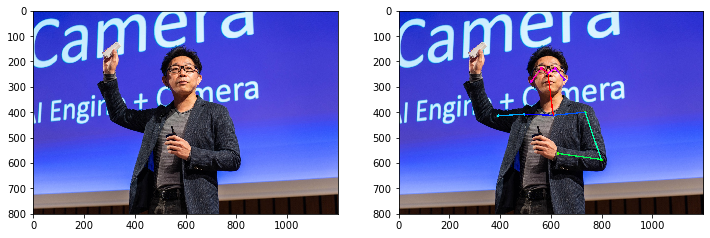

In [25]:
mshow(img1,image_draw1)

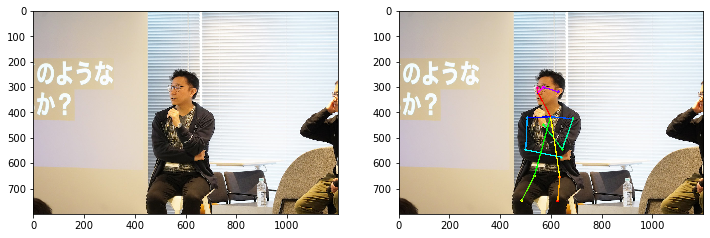

In [26]:
mshow(img2,image_draw2)

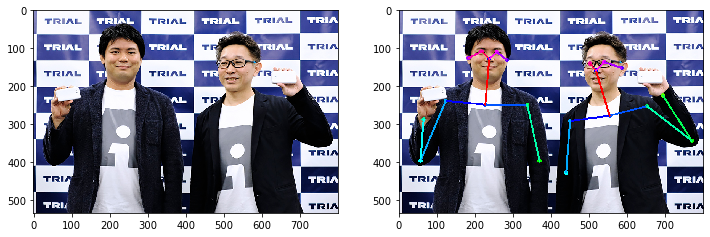

In [27]:
mshow(img3,image_draw3)

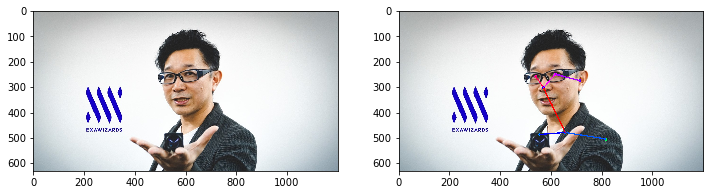

In [28]:
mshow(img4,image_draw4)

In [14]:
# per human
hid = 0
fid = 0

for human in humans:
    hid = hid + 1

    # per body_part
    centers = {}
    for i in range(common.CocoPart.Background.value):
        if i not in human.body_parts.keys():
            continue

        body_part = human.body_parts[i]
        center = (int(body_part.x * image_w + 0.5), int(body_part.y * image_h + 0.5))
        centers[i] = center
        list = [[fid, hid, i, center[0], center[1]]]
        
        ##############################
        #ここから人ごと、関節ごとの処理を書く
        #############################
        
        
#         df = pd.DataFrame(data=list, columns=columns)
        # add list to dfs
#         dfs = pd.concat([dfs, df])

NameError: name 'image_w' is not defined